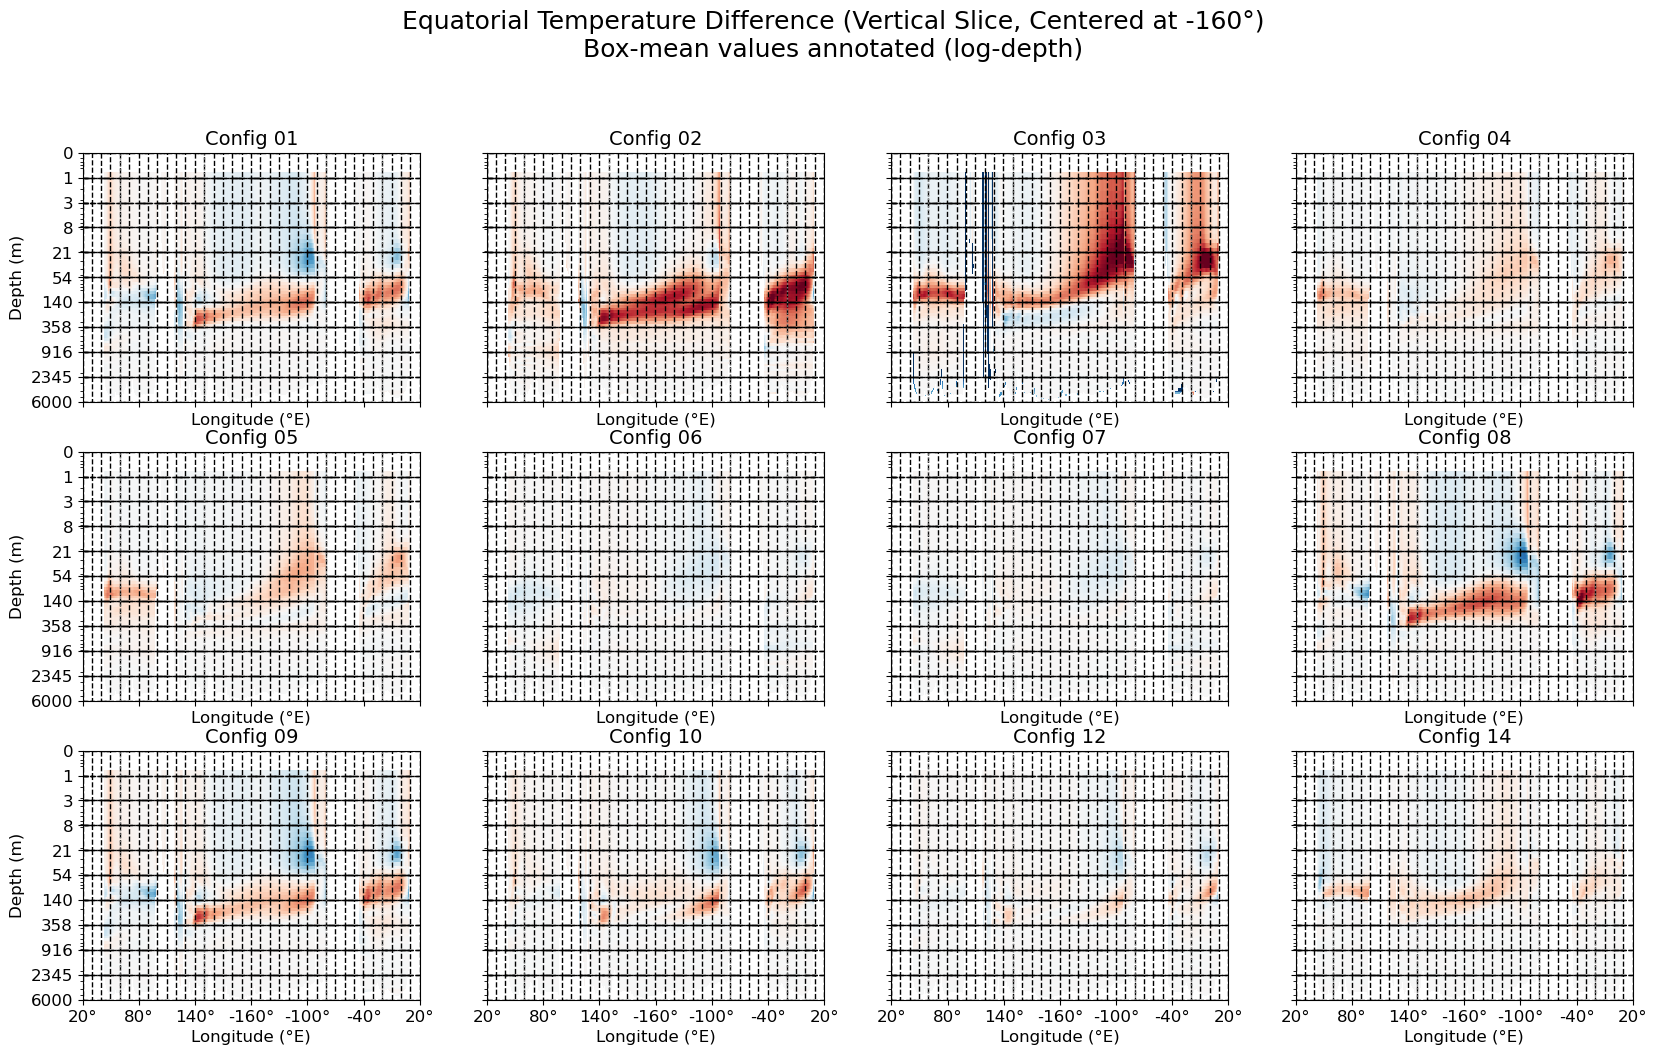

In [10]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- Paths and Constants ---
DATA_DIR = os.path.expanduser("~/NEMOCheck/data/model")
MESH_PATH = os.path.expanduser("~/NEMOCheck/data/model/orca05l75_domain_cfg_nemov5_10m.nc")
CFG_IDS = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "14"]
Y_EQ = 249  # Equator band index
CENTER_LON = -160  # Center longitude for the plot

BOXES = []
# Longitude bins: -180 to 180, step 30
longitudes = list(range(-180, 180, 20))
N = 10
d_min, d_max = 0.5, 6000
depth_edges = np.logspace(np.log10(d_min), np.log10(d_max), N+1)

# Pair up depth edges for intervals
for i in range(len(depth_edges)-1):
    d1 = depth_edges[i]
    d2 = depth_edges[i+1]
    for lo1 in longitudes:
        lo2 = lo1 + 30
        BOXES.append((
            f"Lon {lo1} to {lo2}, depth {int(d1)} to {int(d2)}",
            lo1, lo2,
            d2, d1   # Note: from deeper (more negative) to shallower (closer to 0)
        ))

def wrap180(lon):
    "Convert longitude to [-180, 180]."
    return ((lon + 180) % 360) - 180

def center_longitude(lon, center):
    """Shift and wrap longitude array so that 'center' is in the center of the plot."""
    shifted = ((lon - center + 180) % 360) - 180 + center
    return shifted

def get_grid_info(var, ds, mesh, y):
    dims = ds[var].dims
    nlev, nx = mesh.sizes["nav_lev"], mesh.sizes["x"]
    bottom = mesh.bottom_level.sel(y=y).values
    e3_1d = mesh.e3t_1d.values
    if "y_grid_T" in dims:
        nav_lon = mesh.glamf.sel(y=y).values
        e3_0 = mesh.e3t_0.sel(y=y).values
    elif "y_grid_U" in dims:
        nav_lon = mesh.glamt.sel(y=y).values
        e3_0 = mesh.e3u_0.sel(y=y).values
    else:
        raise ValueError(f"Unknown grid for {var} {dims}")

    valid_mask = np.zeros((nlev, nx), dtype=bool)
    for x in range(nx):
        valid_mask[:bottom[x], x] = True

    depth_2d = np.tile(e3_1d[:, None], (1, nx))
    for x in range(nx):
        level = bottom[x]
        depth_2d[level-1, x] = e3_0[level-1, x]  # e3_0 is (nlev, nx)

    depth_cumsum_2d = -np.cumsum(depth_2d, axis=0)
    sort_idx = np.argsort(nav_lon)
    depth_cumsum_2d_sorted = depth_cumsum_2d[:, sort_idx]
    depth_cumsum_2d_sorted_padded = np.pad(depth_cumsum_2d_sorted, ((1,0),(0,0)), 'constant')
    nav_lon_sorted = nav_lon[sort_idx]
    return dict(
        nav_lon=nav_lon,
        nav_lon_sorted=nav_lon_sorted,
        valid_mask=valid_mask,
        depth_cumsum_2d_sorted=depth_cumsum_2d_sorted,
        depth_cumsum_2d_sorted_padded=depth_cumsum_2d_sorted_padded,
        sort_idx=sort_idx,
        nlev=nlev,
        nx=nx,
        depth_2d=depth_2d,
        depth_cumsum_2d=depth_cumsum_2d
    )

def get_text_contrast_color(rgb):
    """Return black or white for best contrast with input RGB triple [0-1]."""
    lum = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return "black" if lum > 0.5 else "white"

# --- Load Mesh and Reference ---
mesh = xr.open_dataset(MESH_PATH)
ref_ds = xr.open_dataset(os.path.join(DATA_DIR, "nemo00_1m_201001_202212_Eq.nc"))
ref_temp = ref_ds["to"].mean("time_counter")
ref_lat, ref_lon = ref_ds["nav_lat_grid_T"], ref_ds["nav_lon_grid_T"]
equatorial_mask = (-1 <= ref_lat) & (ref_lat <= 1)
ref_eq_temp = ref_temp.where(equatorial_mask).mean("y_grid_T")

ref_grid = get_grid_info("to", ref_ds, mesh, Y_EQ)
sort_idx, nav_sorted = ref_grid["sort_idx"], ref_grid["nav_lon_sorted"]
depth_padded = ref_grid["depth_cumsum_2d_sorted_padded"]
depth_cumsum_2d = ref_grid["depth_cumsum_2d"]
depth_axis = np.mean(depth_cumsum_2d, axis=1)

# --- Center longitude for reference ---
nav_lon_centered = center_longitude(nav_sorted, CENTER_LON)
center_idx = np.argsort(nav_lon_centered)
nav_lon_centered = nav_lon_centered[center_idx]
depth_padded_centered = depth_padded[:, center_idx]
ref_eq_temp_centered = ref_eq_temp.values[:, sort_idx][:, center_idx]

# --- Convert depth arrays to positive before plotting ---
depth_padded_centered = np.abs(depth_padded_centered)
depth_edges_pos = np.abs(depth_edges)
depth_axis_pos = np.abs(depth_axis)

# ---- Remove zero depth for log scale ----
# For plotting, only use depths > 0
nonzero_mask = depth_edges_pos > 0
depth_edges_log = depth_edges_pos[nonzero_mask]
# For pcolormesh, we need depth_padded_centered[1:,...] (skip 0) for y-coords
depth_padded_centered_log = depth_padded_centered[1:, :]

# Also mask the corresponding data in diff arrays
depth_axis_log = depth_axis_pos[1:]

# --- Preload all datasets for performance ---
all_datasets = []
for cfg in CFG_IDS:
    ds = xr.open_dataset(os.path.join(DATA_DIR, f"nemo{cfg}_1m_201001_202212_Eq.nc"))
    all_datasets.append(ds)

# --- Plotting ---
plt.rcParams.update({'font.size': 12})

ncols = 4
nrows = -(-len(CFG_IDS)//ncols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 3*nrows+2), sharex=True, sharey=True)
axs = axs.flat

# Choose colorblind-friendly colormap (or fallback)
try:
    import cmocean
    cmap = cmocean.cm.balance
except ImportError:
    cmap = plt.get_cmap("RdBu_r")

vmin, vmax = -2, 2
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Dummy mappable for consistent colorbar
dummy = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for i, (cfg, ds) in enumerate(zip(CFG_IDS, all_datasets)):
    eq_temp = ds["to"].mean("time_counter").where(equatorial_mask).mean("y_grid_T")
    grid = get_grid_info("to", ds, mesh, Y_EQ)
    mask = grid["valid_mask"][:, sort_idx]
    eq_temp_centered = eq_temp.values[:, sort_idx][:, center_idx]
    diff = np.where(mask[:, center_idx], eq_temp_centered - ref_eq_temp_centered, np.nan)
    # Only plot depths > 0 for log scale
    diff_log = diff[1:, :]
    im = axs[i].pcolormesh(
        nav_lon_centered, depth_padded_centered_log, diff_log[:, 1:],
        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto"
    )
    axs[i].set_yscale('log')
    axs[i].set_ylim(depth_edges_log[-1], depth_edges_log[0])  # Invert y-axis for log scale
    axs[i].set_yticks(depth_edges_log)
    axs[i].set_yticklabels([str(int(d)) for d in depth_edges_log])
    axs[i].set_title(f"Config {cfg}", fontsize=14)
    axs[i].set_xlabel("Longitude (°E)")
    if i % ncols == 0:
        axs[i].set_ylabel("Depth (m)")
    xt = np.linspace(np.nanmin(nav_lon_centered), np.nanmax(nav_lon_centered), 7)
    axs[i].set_xticks(xt)
    axs[i].set_xticklabels([f"{wrap180(l):.0f}°" for l in xt])
    axs[i].set_xlim(np.nanmin(nav_lon_centered), np.nanmax(nav_lon_centered))

    # Optional: vertical lines for major ocean basin boundaries
    for lon in [-80, -20, 60, 150]:
        lon_c = center_longitude(np.array([lon]), CENTER_LON)[0]
        axs[i].axvline(lon_c, color='gray', lw=1, ls=':', zorder=20)

    # Compute and visualize mean difference in each box (robust against empty slices)
    for box in BOXES:
        name, lon_min, lon_max, depth_min, depth_max = box

        # Center the box bounds to match the centered longitude grid
        box_lon_min = center_longitude(np.array([lon_min]), CENTER_LON)[0]
        box_lon_max = center_longitude(np.array([lon_max]), CENTER_LON)[0]

        # Check if the box wraps (now, in centered coords)
        if box_lon_min < box_lon_max:
            lon_mask = (nav_lon_centered >= box_lon_min) & (nav_lon_centered <= box_lon_max)
            rects = [ (box_lon_min, box_lon_max) ]
        else:
            lon_mask = (nav_lon_centered >= box_lon_min) | (nav_lon_centered <= box_lon_max)
            rects = [
                (box_lon_min, np.nanmax(nav_lon_centered)),
                (np.nanmin(nav_lon_centered), box_lon_max)
            ]
        # Use positive depths for masking and plotting, skip 0
        dmin_pos = np.abs(depth_min)
        dmax_pos = np.abs(depth_max)
        if dmin_pos == 0 or dmax_pos == 0:
            continue  # skip boxes that touch 0 for log scale
        # depth_axis_log for index, since we skipped 0
        depth_mask = (depth_axis_log > dmin_pos) & (depth_axis_log <= dmax_pos)
        box_vals = diff_log[depth_mask, :][:, lon_mask]
        valid_vals = box_vals[np.isfinite(box_vals)]
        if valid_vals.size > 0:
            mean_val = np.mean(valid_vals)
            # For log scale, center annotation at geometric mean of bounds
            box_depth_center = np.sqrt(dmin_pos * dmax_pos)
            box_lon_center = (box_lon_min + box_lon_max)/2 if box_lon_min < box_lon_max else wrap180(((box_lon_min + (box_lon_max+360))/2))
            color_val = cmap(norm(mean_val))
            text_color = get_text_contrast_color(color_val)
            axs[i].text(
                box_lon_center, box_depth_center,
                f"{mean_val:.2f}",
                color=text_color, fontsize=10, fontweight="bold",
                ha="center", va="center",
                bbox=dict(facecolor='white', edgecolor='k', alpha=0.8, boxstyle="round,pad=0.2")
            )
        # Draw rectangles on the centered grid, use positive depths (skip 0)
        for lo, hi in rects:
            axs[i].add_patch(
                plt.Rectangle(
                    (lo, dmin_pos), hi-lo, dmax_pos-dmin_pos,
                    edgecolor="k", facecolor="none", lw=1.0, linestyle='--', zorder=10
                )
            )

#fig.colorbar(dummy, cax=cbar_ax, label="ΔTemperature vs 00 (°C)")
fig.suptitle(f"Equatorial Temperature Difference (Vertical Slice, Centered at {wrap180(CENTER_LON):.0f}°)\nBox-mean values annotated (log-depth)", fontsize=18, y=1.01)
plt.show()

# Idea
- imshow for moved picture on purpose
- significant boxes in a color
- RMSE and not mean